In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(18981, 24)
(18981, 4)


In [6]:
min(Y_footsteps_accelerations_absolute[:, 0])

-0.3687813123494827

In [7]:
max(Y_footsteps_accelerations_absolute[:, 0])

0.8620843228555446

# Multivariate Linear Regression (Foot prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [9]:
# Entries where FL is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_FL_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FL_swinging = Y_footsteps_accelerations_absolute[idxs]

In [10]:
len(idxs)

9494

In [11]:
X_footsteps_accelerations_absolute_FL_swinging[0]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        , -0.01028383, -0.00927643,  0.00343832, -0.05098958,
        0.24717499,  0.12979011, -0.38015699,  0.23568314, -0.12657437,
       -0.38787624, -0.26431972,  0.12493423, -0.39093262, -0.25490147,
       -0.12512474, -0.38337615,  1.        ,  0.        ])

In [12]:
Y_footsteps_accelerations_absolute[0]

array([0.00412931, 0.00261517, 0.00625249, 0.00055512])

## Predict FL foot -> x

### Linear Regression

In [13]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [14]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous reference velocity,
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_x = find_best_model(X, Y, runs=5000)

R2:  0.9941481805419008
RMSE:  0.016529761276999982
The lowest error is:  2.1381786438331996e-05
The highest error is:  0.06955791815556901
The avg. error is:  0.012087580190722862


In [15]:
model_fl_relative_support_x.coef_

array([[ 0.13425642,  0.04440987,  0.31318025, -0.82261151, -0.1726768 ,
        -1.28514097,  0.69416782,  0.72024664, -0.03341558, -0.61090385,
        -0.54472856]])

In [16]:
model_fl_relative_support_x.intercept_

array([0.58157249])

In [17]:
#inp = np.array([[0.9, 0.661, 0.159, 0.124, 0.331, -0.137, -0.169, 0.119, -0.337, -0.127]])

In [18]:
#out = model_fl_relative_support_x.coef_ @ inp.T
#out += model_fl_relative_support_x.intercept_
#print(out)

Text(0, 0.5, 'Predictions')

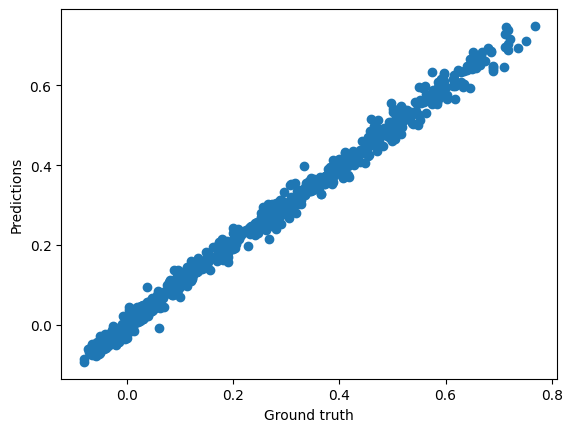

In [19]:
# The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'{X_test[idx, 0]} -> {X_test[idx, 3]}. CoM: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}.')

### Predict FL foot -> y

In [21]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FL_swinging[:, 0:1], # previous reference velocity,
               X_footsteps_accelerations_absolute_FL_swinging[:, 3:4], # current reference velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 6:7], # actual velocity
               X_footsteps_accelerations_absolute_FL_swinging[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_FL_swinging[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_FL_swinging[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fl_relative_support_y = find_best_model(X, Y, runs=5000)

R2:  0.9097804624250772
RMSE:  0.00924983056830578
The lowest error is:  2.1905671695292284e-06
The highest error is:  0.03228077341781546
The avg. error is:  0.006863419441561399


In [22]:
model_fl_relative_support_y.coef_

array([[ 0.00759202, -0.01038824,  0.09155511,  0.21189849, -1.72705035,
         0.05052868,  0.52961249, -0.54124066,  0.27099776, -0.26092137,
        -0.32862838]])

In [23]:
model_fl_relative_support_y.intercept_

array([-0.05724075])

Text(0, 0.5, 'Predictions')

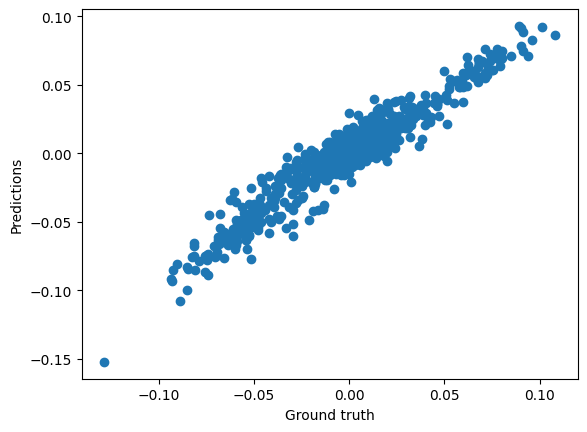

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')